# Importing all libraries

In [1]:
%matplotlib inline
import warnings
warnings.filterwarnings("ignore")
import sqlite3
import pandas as pd
import numpy as np
import nltk
import string
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.feature_extraction.text import TfidfTransformer
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.model_selection import GridSearchCV
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import Normalizer
from sklearn.metrics import confusion_matrix
from sklearn import metrics
from sklearn.metrics import roc_curve, auc
from nltk.stem.porter import PorterStemmer
import re
from nltk.corpus import stopwords
from nltk.stem import PorterStemmer
from nltk.stem.wordnet import WordNetLemmatizer
from gensim.models import Word2Vec
from gensim.models import KeyedVectors
import pickle
from tqdm import tqdm
import os
from os import path
from PIL import Image
from wordcloud import WordCloud, STOPWORDS, ImageColorGenerator
from plotly import plotly
import plotly.offline as offline
import plotly.graph_objs as go
offline.init_notebook_mode()
from collections import Counter
from sklearn.tree import DecisionTreeClassifier
from sklearn.tree import export_graphviz
from prettytable import PrettyTable
import csv
import math
from nltk.sentiment.vader import SentimentIntensityAnalyzer
from wordcloud import WordCloud, STOPWORDS 
from sklearn.neighbors import NearestNeighbors
import pickle
import numpy as np
import matplotlib.pyplot as plt
from sklearn.cluster import DBSCAN
import pickle
import pandas as pd
# Start with loading all necessary libraries
import numpy as np
import pandas as pd
from os import path
from PIL import Image
from wordcloud import WordCloud, STOPWORDS, ImageColorGenerator

import matplotlib.pyplot as plt

## Reading Data

In [2]:
# https://github.com/pandas-dev/pandas/issues/11493
# https://stackoverflow.com/questions/52105659/pandas-read-csv-unexpected-end-of-data-error

project_data = pd.read_csv('train_data.csv', engine='python', error_bad_lines=False)
resource_data = pd.read_csv('resources.csv', engine='python', error_bad_lines=False)

## Combining both data frames

In [3]:
'''https://stackoverflow.com/questions/43297589/merge-two-data-
frames-based-on-common-column-values-in-pandas'''
project_data = pd.merge(project_data, resource_data, on='id')

In [4]:
project_data = project_data[:5000]

In [5]:
project_data.shape

(5000, 20)

## Preprocessing data

### Preprocessing project_submitted_datetime column

In [6]:
# https://stackoverflow.com/a/2582163/4084039
cols = ['Date' if x=='project_submitted_datetime' else x for x in list(project_data.columns)]

# https://stackoverflow.com/a/49702492/4084039
project_data['Date'] = pd.to_datetime(project_data['project_submitted_datetime'])
project_data.drop('project_submitted_datetime', axis = 'columns', inplace=True)
project_data.sort_values(by=['Date'], inplace=True)

# https://stackoverflow.com/a/13148611/4084039
project_data = project_data[cols]

In [7]:
# consider we have text like this "Math & Science, Warmth, Care & Hunger"
# it will split it in three parts ["Math & Science", "Warmth", "Care & Hunger"]
# this will split each of the catogory based on space "Math & Science"=> "Math","&", "Science"
# if we have the words "The" we are going to replace it with ''(i.e removing 'The')
# we are placeing all the ' '(space) with ''(empty) ex:"Math & Science"=>"Math&Science"
#" abc ".strip() will return "abc", remove the trailing spaces
# we are replacing the & value into _

def preprocess(param1):
    lst=list()
    for i in param1:
        temp=''
        for j in i.split(','):
            if 'The' in j.split():
                j=j.replace('The', '')
            j=j.replace(' ', '')
            j=j.lower()
            temp+=j.strip()+ ' '
            temp = temp.replace('&', '_')
        lst.append(temp.strip())
    return lst

### Preprocessing of project_subject_categories

In [8]:
# https://stackoverflow.com/a/47301924/4084039
# https://www.geeksforgeeks.org/removing-stop-words-nltk-python/
# https://stackoverflow.com/questions/23669024/how-to-strip-a-specific-word-from-a-string
# https://stackoverflow.com/questions/8270092/remove-all-whitespace-in-a-string-in-python


categories = list(project_data['project_subject_categories'].values)

project_data['clean_categories'] = preprocess(categories)
project_data.drop(['project_subject_categories'], axis='columns', inplace=True)



cnt = Counter()
for word in project_data['clean_categories'].values:
    cnt.update(word.split())

cat_dict = dict(cnt)
sorted_cat_dict = dict(sorted(cat_dict.items(), key=lambda kv:kv[1]))
        

### Preprocessing of project_subject_subcategories

In [9]:
# https://stackoverflow.com/a/47301924/4084039
# https://www.geeksforgeeks.org/removing-stop-words-nltk-python/
# https://stackoverflow.com/questions/23669024/how-to-strip-a-specific-word-from-a-string
# https://stackoverflow.com/questions/8270092/remove-all-whitespace-in-a-string-in-python


sub_categories = list(project_data['project_subject_subcategories'].values)

project_data['clean_subcategories'] = preprocess(sub_categories)
project_data.drop(['project_subject_subcategories'], axis='columns', inplace=True)



cnt = Counter()
for word in project_data['clean_subcategories'].values:
    cnt.update(word.split())

sub_cat_dict = dict(cnt)
sorted_sub_cat_dict = dict(sorted(sub_cat_dict.items(), key=lambda kv:kv[1]))
        

### Preprocessing teacher_prefix column

In [10]:
project_data['teacher_prefix'] = project_data['teacher_prefix'].fillna("")
teacher_pfx = list(project_data['teacher_prefix'].values)

teacher_pfx_list = []
for i in teacher_pfx:
    temp = ""
    for j in i.split(','):
        if 'The' in j.split():
            j=j.replace('The', '')
        j = j.replace('.','')
        j = j.lower()
        temp +=j.strip()+" "
    teacher_pfx_list.append(temp.strip()) 
    
project_data['clean_teacher_prefix'] = teacher_pfx_list
project_data.drop(['teacher_prefix'], axis=1, inplace=True)

# count of all the words in corpus
my_counter = Counter()
for word in project_data['clean_teacher_prefix'].values:
    my_counter.update(word.split())

teacher_prefix_dict = dict(my_counter)
sorted_teacher_prefix_dict = dict(sorted(teacher_prefix_dict.items(), key=lambda kv:kv[1]))


### Preprocessing project_grade_category column

In [11]:
prj_grd_cat = list(project_data['project_grade_category'].values)

prj_grd_cat_list = []
for i in prj_grd_cat:
    temp = ""
    for j in i.split(','):
        if 'The' in j.split():
            j=j.replace('The', '')
        j = j.replace(' ','_')
        j = j.replace('-','_')
        j = j.lower()
        temp +=j.strip()+" "
    prj_grd_cat_list.append(temp.strip()) 
    
project_data['clean_project_grade_category'] = prj_grd_cat_list
project_data.drop(['project_grade_category'], axis=1, inplace=True)

# count of all the words in corpus
my_counter = Counter()
for word in project_data['clean_project_grade_category'].values:
    my_counter.update(word.split())

project_grade_category_dict = dict(my_counter)
sorted_project_grade_category_dict = dict(sorted(project_grade_category_dict.items(), key=lambda kv:kv[1]))

### Preprocessing school_state column

In [12]:
state = list(project_data['school_state'].values)

state_list = []
for i in state:
    temp = ""
    for j in i.split(','):
        if 'The' in j.split():
            j=j.replace('The', '')
        j = j.replace(' ','_')
        j=j.lower()
        temp +=j.strip()+" "
        temp = temp.replace('&','')
    state_list.append(temp.strip()) 
    
project_data['clean_state'] = state_list

project_data.drop(['school_state'], axis=1, inplace=True)

# count of all the words in corpus
my_counter = Counter()
for word in project_data['clean_state'].values:
    my_counter.update(word.split())

state_dict = dict(my_counter)
sorted_state_dict = dict(sorted(state_dict.items(), key=lambda kv:kv[1]))

### Merging essay_(#) to essay single column

In [13]:
# merge two column text dataframe: 
project_data["essay"] = project_data["project_essay_1"].map(str) +\
                        project_data["project_essay_2"].map(str) + \
                        project_data["project_essay_3"].map(str) + \
                        project_data["project_essay_4"].map(str)

In [14]:
# https://stackoverflow.com/a/47091490/4084039

def decontracted(phrase):
    # specific
    phrase = re.sub(r"won't", "will not", phrase)
    phrase = re.sub(r"can\'t", "can not", phrase)

    # general
    phrase = re.sub(r"n\'t", " not", phrase)
    phrase = re.sub(r"\'re", " are", phrase)
    phrase = re.sub(r"\'s", " is", phrase)
    phrase = re.sub(r"\'d", " would", phrase)
    phrase = re.sub(r"\'ll", " will", phrase)
    phrase = re.sub(r"\'t", " not", phrase)
    phrase = re.sub(r"\'ve", " have", phrase)
    phrase = re.sub(r"\'m", " am", phrase)
    return phrase

In [15]:
# https://gist.github.com/sebleier/554280
# we are removing the words from the stop words list: 'no', 'nor', 'not'
stopwords= ['i', 'me', 'my', 'myself', 'we', 'our', 'ours', 'ourselves', 'you', "you're", "you've",\
            "you'll", "you'd", 'your', 'yours', 'yourself', 'yourselves', 'he', 'him', 'his', 'himself', \
            'she', "she's", 'her', 'hers', 'herself', 'it', "it's", 'its', 'itself', 'they', 'them', 'their',\
            'theirs', 'themselves', 'what', 'which', 'who', 'whom', 'this', 'that', "that'll", 'these', 'those', \
            'am', 'is', 'are', 'was', 'were', 'be', 'been', 'being', 'have', 'has', 'had', 'having', 'do', 'does', \
            'did', 'doing', 'a', 'an', 'the', 'and', 'but', 'if', 'or', 'because', 'as', 'until', 'while', 'of', \
            'at', 'by', 'for', 'with', 'about', 'against', 'between', 'into', 'through', 'during', 'before', 'after',\
            'above', 'below', 'to', 'from', 'up', 'down', 'in', 'out', 'on', 'off', 'over', 'under', 'again', 'further',\
            'then', 'once', 'here', 'there', 'when', 'where', 'why', 'how', 'all', 'any', 'both', 'each', 'few', 'more',\
            'most', 'other', 'some', 'such', 'only', 'own', 'same', 'so', 'than', 'too', 'very', \
            's', 't', 'can', 'will', 'just', 'don', "don't", 'should', "should've", 'now', 'd', 'll', 'm', 'o', 're', \
            've', 'y', 'ain', 'aren', "aren't", 'couldn', "couldn't", 'didn', "didn't", 'doesn', "doesn't", 'hadn',\
            "hadn't", 'hasn', "hasn't", 'haven', "haven't", 'isn', "isn't", 'ma', 'mightn', "mightn't", 'mustn',\
            "mustn't", 'needn', "needn't", 'shan', "shan't", 'shouldn', "shouldn't", 'wasn', "wasn't", 'weren', "weren't", \
            'won', "won't", 'wouldn', "wouldn't"]

### Preprocessing of essay column

In [16]:
preprocessed_essays = list()
# tqdm is for printing the status bar
for sentance in tqdm(project_data['essay'].values):
    sent = decontracted(sentance)
    sent = sent.replace('\\r', ' ')
    sent = sent.replace('\\"', ' ')
    sent = sent.replace('\\n', ' ')
    sent = re.sub('[^A-Za-z0-9]+', ' ', sent)
    # https://gist.github.com/sebleier/554280
    sent = ' '.join(e for e in sent.split() if e.lower() not in stopwords)
    preprocessed_essays.append(sent.lower().strip())
project_data['clean_essays'] = preprocessed_essays
project_data.drop('essay', axis=1, inplace=True)

100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████| 5000/5000 [00:03<00:00, 1311.34it/s]


### Computing Sentiment Scores of clean_essays

In [17]:
from nltk.sentiment.vader import SentimentIntensityAnalyzer
import nltk
nltk.download('vader_lexicon')

sid = SentimentIntensityAnalyzer()
neg_score = list()
neu_score = list()
pos_score = list()
compound_score = list()
for essay in tqdm(project_data['clean_essays'].values):
    ss = sid.polarity_scores(essay)
    neg_score.append(ss['neg'])
    neu_score.append(ss['neu'])
    pos_score.append(ss['pos']) 
    compound_score.append(ss['compound'])   
project_data['sentiment_score_neg'] = neg_score
project_data['sentiment_score_neu'] = neu_score
project_data['sentiment_score_pos'] = pos_score
project_data['sentiment_score_compound'] = compound_score
project_data['sentiment_score_neg'] = project_data['sentiment_score_neg'].astype(float)
project_data['sentiment_score_neu'] = project_data['sentiment_score_neu'].astype(float)
project_data['sentiment_score_pos'] = project_data['sentiment_score_pos'].astype(float)
project_data['sentiment_score_compound'] = project_data['sentiment_score_compound'].astype(float)

[nltk_data] Downloading package vader_lexicon to
[nltk_data]     /home/jupyter/nltk_data...
[nltk_data]   Package vader_lexicon is already up-to-date!
100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████| 5000/5000 [00:10<00:00, 485.99it/s]


### Computing number of words in clean_essays

In [18]:
essay_length = list()
for essay in tqdm(project_data['clean_essays'].values):
    length = len(essay)
    essay_length.append(length)
project_data['clean_essay_length'] = essay_length
project_data['clean_essay_length'] = project_data['clean_essay_length'].astype(float)

100%|██████████████████████████████████████████████████████████████████████████████████████████████████████| 5000/5000 [00:00<00:00, 1270847.17it/s]


In [19]:
project_data['clean_essays'].to_csv('Essay.csv')

### Preprocessing of project_title column

In [20]:
preprocessed_titles = []
# tqdm is for printing the status bar
for sentence in tqdm(project_data['project_title'].values):
    sent2 = decontracted(sentence)
    sent2 = sent2.replace('\\r', ' ')
    sent2 = sent2.replace('\\"', ' ')
    sent2 = sent2.replace('\\n', ' ')
    sent2 = re.sub('[^A-Za-z0-9]+', ' ', sent2)
    # https://gist.github.com/sebleier/554280
    sent2 = ' '.join(e for e in sent2.split() if e not in stopwords)
    preprocessed_titles.append(sent2.lower().strip())
    
project_data['clean_project_title'] = preprocessed_titles
project_data.drop('project_title', axis=1, inplace=True)

100%|████████████████████████████████████████████████████████████████████████████████████████████████████████| 5000/5000 [00:00<00:00, 32476.72it/s]


### Computing number of words in clean_project_title

In [21]:
title_length = list()
for title in tqdm(project_data['clean_project_title'].values):
    length = len(title)
    title_length.append(length)
project_data['clean_title_length'] = title_length
project_data['clean_title_length'] = project_data['clean_title_length'].astype(float)

100%|██████████████████████████████████████████████████████████████████████████████████████████████████████| 5000/5000 [00:00<00:00, 1353437.88it/s]


## Splitting into Train and Test

In [22]:
y = project_data['project_is_approved'].values
project_data.drop(['project_is_approved'], axis='columns', inplace=True)
X = project_data

In [23]:
# train test split
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, stratify=y)

In [24]:
print(X_test.columns)

Index(['Unnamed: 0', 'id', 'teacher_id', 'Date', 'project_essay_1',
       'project_essay_2', 'project_essay_3', 'project_essay_4',
       'project_resource_summary',
       'teacher_number_of_previously_posted_projects', 'description',
       'quantity', 'price', 'clean_categories', 'clean_subcategories',
       'clean_teacher_prefix', 'clean_project_grade_category', 'clean_state',
       'clean_essays', 'sentiment_score_neg', 'sentiment_score_neu',
       'sentiment_score_pos', 'sentiment_score_compound', 'clean_essay_length',
       'clean_project_title', 'clean_title_length'],
      dtype='object')


In [25]:
print(len(y_test))

1500


## Creating Dataframe for Test only

In [26]:
df = {'id':X_test['id'], 'price':X_test['price'], 'essay':X_test['clean_essays'], \
      'teacher_number_of_previously_posted_projects':X_test['teacher_number_of_previously_posted_projects'], \
      'project_is_approved':y_test}
test_df = pd.DataFrame(data=df)

In [27]:
print(test_df.shape)

(1500, 5)


In [28]:
with open('Test_df.pickle', 'wb') as f:
    pickle.dump(test_df, f)

## Storing vocabulary in a list

In [29]:
vocabulary = list()
vocabulary_bow = list()
vocabulary_tfidf = list()

## Make Data Model Ready

### Vectorizing Categorical Data

In [30]:
def categorical_vectorization(train_column, test_column):
    vectorizer = CountVectorizer()
    vectorizer.fit(train_column)
    X_train_val_ohe = vectorizer.transform(train_column)
    X_test_val_ohe = vectorizer.transform(test_column)
    ft_name = vectorizer.get_feature_names()
    vocab = vectorizer.vocabulary_
    return (X_train_val_ohe, X_test_val_ohe, ft_name, vocab)

#### clean_state column

In [31]:
tra1 = X_train['clean_state'].values
tes1 = X_test['clean_state'].values
X_train_state_ohe, X_test_state_ohe, feat1, clean_state_vocab = categorical_vectorization(tra1, tes1)

print("After vectorizations")
print(X_train_state_ohe.shape, y_train.shape)
print(X_test_state_ohe.shape, y_test.shape)
print(feat1)
print("="*100)
vocabulary.extend(clean_state_vocab.keys())

After vectorizations
(3500, 47) (3500,)
(1500, 47) (1500,)
['ak', 'al', 'ar', 'az', 'ca', 'co', 'ct', 'dc', 'de', 'fl', 'ga', 'hi', 'ia', 'id', 'il', 'in', 'ky', 'la', 'ma', 'md', 'me', 'mi', 'mn', 'mo', 'ms', 'nc', 'nd', 'ne', 'nj', 'nm', 'nv', 'ny', 'oh', 'ok', 'or', 'pa', 'ri', 'sc', 'sd', 'tn', 'tx', 'ut', 'va', 'wa', 'wi', 'wv', 'wy']


#### clean_categories

In [32]:
tra2 = X_train['clean_categories'].values
tes2 = X_test['clean_categories'].values
X_train_clean_categories_ohe, X_test_clean_categories_ohe, feat2, clean_categories_vocab = categorical_vectorization(tra2, tes2)
print("After vectorizations")
print(X_train_clean_categories_ohe.shape, y_train.shape)
print(X_test_clean_categories_ohe.shape, y_test.shape)
print(feat2)
print("="*100)
vocabulary.extend(clean_categories_vocab.keys())

After vectorizations
(3500, 9) (3500,)
(1500, 9) (1500,)
['appliedlearning', 'care_hunger', 'health_sports', 'history_civics', 'literacy_language', 'math_science', 'music_arts', 'specialneeds', 'warmth']


#### clean_subcategories 

In [33]:
tra3 = X_train['clean_subcategories'].values
tes3 = X_test['clean_subcategories'].values
X_train_clean_subcategories_ohe, X_test_clean_subcategories_ohe, feat3, clean_subcategories_vocab = categorical_vectorization(tra3, tes3)
print("After vectorizations")
print(X_train_clean_subcategories_ohe.shape, y_train.shape)
print(X_test_clean_subcategories_ohe.shape, y_test.shape)
print(feat3)
print("="*100)
vocabulary.extend(clean_subcategories_vocab.keys())

After vectorizations
(3500, 29) (3500,)
(1500, 29) (1500,)
['appliedsciences', 'care_hunger', 'charactereducation', 'civics_government', 'college_careerprep', 'communityservice', 'earlydevelopment', 'economics', 'environmentalscience', 'esl', 'financialliteracy', 'foreignlanguages', 'gym_fitness', 'health_lifescience', 'health_wellness', 'history_geography', 'literacy', 'literature_writing', 'mathematics', 'music', 'nutritioneducation', 'other', 'parentinvolvement', 'performingarts', 'socialsciences', 'specialneeds', 'teamsports', 'visualarts', 'warmth']


#### clean_project_grade_category

In [34]:
tra4 = X_train['clean_project_grade_category'].values
tes4 = X_test['clean_project_grade_category'].values
X_train_clean_project_grade_category_ohe, X_test_clean_project_grade_category_ohe, \
feat4, clean_project_grade_category_vocab = categorical_vectorization(tra4, tes4)
print("After vectorizations")
print(X_train_clean_project_grade_category_ohe.shape, y_train.shape)
print(X_test_clean_project_grade_category_ohe.shape, y_test.shape)
print(feat4)
print("="*100)
vocabulary.extend(clean_project_grade_category_vocab.keys())

After vectorizations
(3500, 4) (3500,)
(1500, 4) (1500,)
['grades_3_5', 'grades_6_8', 'grades_9_12', 'grades_prek_2']


#### clean_teacher_prefix 

In [35]:
tra5 = X_train['clean_teacher_prefix'].values
tes5 = X_test['clean_teacher_prefix'].values
X_train_clean_teacher_prefix_category_ohe, X_test_clean_teacher_prefix_category_ohe, feat5, \
clean_teacher_prefix_vocab = categorical_vectorization(tra5, tes5)
print("After vectorizations")
print(X_train_clean_teacher_prefix_category_ohe.shape, y_train.shape)
print(X_test_clean_teacher_prefix_category_ohe.shape, y_test.shape)
print(feat5)
print("="*100)
vocabulary.extend(clean_teacher_prefix_vocab.keys())

After vectorizations
(3500, 4) (3500,)
(1500, 4) (1500,)
['mr', 'mrs', 'ms', 'teacher']


### Vectorizing Numerical Data

In [36]:
def numerical_vectorization(train_column, test_column):
    normalizer = Normalizer()
    normalizer.fit(train_column)
    X_train_val_norm = normalizer.transform(train_column)
    X_test_val_norm = normalizer.transform(test_column)
    X_train_val_norm = X_train_val_norm.astype(float)
    X_test_val_norm = X_test_val_norm.astype(float)
    return (X_train_val_norm, X_test_val_norm)

#### price

In [37]:
tra6 = X_train['price'].values.reshape(-1,1)
tes6 = X_test['price'].values.reshape(-1,1)
X_train_price_norm, X_test_price_norm = numerical_vectorization(tra6, tes6)
print("After vectorizations")
print(X_train_price_norm.shape, y_train.shape)
print(X_test_price_norm.shape, y_test.shape)
print("="*100)
vocabulary.extend(['price'])

After vectorizations
(3500, 1) (3500,)
(1500, 1) (1500,)


#### teacher_number_of_previously_posted_projects

In [38]:
tra7 = X_train['teacher_number_of_previously_posted_projects'].values.reshape(-1,1)
tes7 = X_test['teacher_number_of_previously_posted_projects'].values.reshape(-1,1)
X_train_teacher_number_of_previously_posted_projects_norm, X_test_teacher_number_of_previously_posted_projects_norm = numerical_vectorization(tra7, tes7)
print("After vectorizations")
print(X_train_teacher_number_of_previously_posted_projects_norm.shape, y_train.shape)
print(X_test_teacher_number_of_previously_posted_projects_norm.shape, y_test.shape)
print("="*100)
vocabulary.extend(['teacher_number_of_previously_posted_projects'])

After vectorizations
(3500, 1) (3500,)
(1500, 1) (1500,)


#### quantity

In [39]:
tra8 = X_train['quantity'].values.reshape(-1,1)
tes8 = X_test['quantity'].values.reshape(-1,1)
X_train_quantity_norm, X_test_quantity_norm = numerical_vectorization(tra8, tes8)
print("After vectorizations")
print(X_train_quantity_norm.shape, y_train.shape)
print(X_test_quantity_norm.shape, y_test.shape)
print("="*100)
vocabulary.extend(['quantity'])

After vectorizations
(3500, 1) (3500,)
(1500, 1) (1500,)


### Loading GloVe

In [40]:
# storing variables into pickle files python: http://www.jessicayung.com/how-to-use-pickle-to-save-and-load-variables-in-python/
# make sure you have the glove_vectors file
with open('glove_vectors', 'rb') as f:
    model = pickle.load(f)
    glove_words =  set(model.keys())

# Text Vectorization

### TFIDF weighted W2V

#### As told telephonically, to take only 1500 features.

In [41]:
def tfidf_w_w2v_fit(column):
    tfidf_model = TfidfVectorizer(min_df=10, ngram_range=(1,2), max_features=1500)
    tfidf_model.fit(column)
    dictionary = dict(zip(tfidf_model.get_feature_names(), list(tfidf_model.idf_)))
    tfidf_words = set(tfidf_model.get_feature_names())
    return (tfidf_words, dictionary)

In [42]:
def tfidf_w_w2v_vectorization(column):
    tfidf_words, dictionary = tfidf_w_w2v_fit(column)
    tfidf_w2v_vectors_lst = list()
    for sentence in tqdm(column):
        vector = np.zeros(300)
        tf_idf_weight = 0
        for word in sentence.split():
            if (word in glove_words) and (word in tfidf_words):
                vec = model[word]
                tf_idf = dictionary[word]*(sentence.count(word)/len(sentence.split()))
                vector += (vec * tf_idf)
                tf_idf_weight += tf_idf
        if tf_idf_weight != 0:
            vector /= tf_idf_weight
        tfidf_w2v_vectors_lst.append(vector)
    return tfidf_w2v_vectors_lst

#### clean_essays (Train)

In [43]:
tra21 = X_train['clean_essays'].values
tfidf_w2v_train_vectors_essays = tfidf_w_w2v_vectorization(tra21)    

print(len(tfidf_w2v_train_vectors_essays))
print(len(tfidf_w2v_train_vectors_essays[0]))

100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████| 3500/3500 [00:05<00:00, 637.30it/s]

3500
300


#### clean_essays (Test)

In [44]:
tes21 = X_test['clean_essays'].values
tfidf_w2v_test_vectors_essays = tfidf_w_w2v_vectorization(tes21)

print(len(tfidf_w2v_test_vectors_essays))
print(len(tfidf_w2v_test_vectors_essays[0]))

100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████| 1500/1500 [00:02<00:00, 647.07it/s]

1500
300


#### clean_project_title (Train)

In [45]:
tra22 = X_train['clean_project_title'].values
tfidf_w2v_train_vectors_titles = tfidf_w_w2v_vectorization(tra22)    

print(len(tfidf_w2v_train_vectors_titles))
print(len(tfidf_w2v_train_vectors_titles[0]))

100%|████████████████████████████████████████████████████████████████████████████████████████████████████████| 3500/3500 [00:00<00:00, 38998.44it/s]

3500
300


#### clean_project_title (Test)

In [46]:
tes22 = X_test['clean_project_title'].values
tfidf_w2v_test_vectors_titles = tfidf_w_w2v_vectorization(tes22)

print(len(tfidf_w2v_test_vectors_titles))
print(len(tfidf_w2v_test_vectors_titles[0]))

100%|████████████████████████████████████████████████████████████████████████████████████████████████████████| 1500/1500 [00:00<00:00, 43369.01it/s]

1500
300


#### Combining

In [47]:
from scipy.sparse import hstack
# Set 4: categorical, numerical features + project_title(TFIDF W2V)+ preprocessed_essay (TFIDF W2V)
X_tr_tfidf_w2v = hstack((X_train_state_ohe, \
                         X_train_clean_categories_ohe, \
                         X_train_clean_subcategories_ohe, \
                         X_train_clean_project_grade_category_ohe, \
                         X_train_clean_teacher_prefix_category_ohe, \
                         X_train_price_norm, \
                         X_train_teacher_number_of_previously_posted_projects_norm, \
                         X_train_quantity_norm, \
                         tfidf_w2v_train_vectors_essays, \
                         tfidf_w2v_train_vectors_titles)).tocsr()
X_test_tfidf_w2v = hstack((X_test_state_ohe, \
                           X_test_clean_categories_ohe, \
                           X_test_clean_subcategories_ohe, \
                           X_test_clean_project_grade_category_ohe, \
                           X_test_clean_teacher_prefix_category_ohe, \
                           X_test_price_norm, \
                           X_test_teacher_number_of_previously_posted_projects_norm, \
                           X_test_quantity_norm, \
                           tfidf_w2v_test_vectors_essays, \
                           tfidf_w2v_test_vectors_titles)).tocsr()
print("Final Data matrix")
print(X_tr_tfidf_w2v.shape, y_train.shape)
print(X_test_tfidf_w2v.shape, y_test.shape)
print("="*100)

Final Data matrix
(3500, 696) (3500,)
(1500, 696) (1500,)


#### Storing TFIDF weighted W2V data into pickle

In [48]:
# https://www.jessicayung.com/how-to-use-pickle-to-save-and-load-variables-in-python/

with open('tfidf_w2v.pickle', 'wb') as f:
    pickle.dump([X_tr_tfidf_w2v, y_train, X_test_tfidf_w2v, y_test], f)

## Applying K-Means

In [49]:
from sklearn.cluster import KMeans
import pickle
import pandas as pd

In [50]:
with open('tfidf_w2v.pickle', 'rb') as f:
    X_tr_tfidf_w2v, y_train, X_test_tfidf_w2v, y_test = pickle.load(f)

In [51]:
# https://www.analyticsvidhya.com/blog/2019/08/comprehensive-guide-k-means-clustering/#k-means-clustering-python-code

SSE = []
for cluster in range(1,20):
    kmeans = KMeans(n_jobs=-1, n_clusters=cluster, init='k-means++')
    kmeans.fit(X_tr_tfidf_w2v)
    SSE.append(kmeans.inertia_)

In [52]:
with open('kmeans_result_inertia', 'wb') as f:
    pickle.dump(SSE, f)

In [1]:
with open('kmeans_result_inertia', 'rb') as f:
    SSE = pickle.load(f)

In [2]:
print(SSE)

[73400.21915400641, 69744.99741863737, 67279.57156440707, 65095.68608476275, 63973.8129224169, 62922.77655855933, 62147.53439032304, 61366.46839514893, 60465.150953342134, 59783.71739282441, 58948.70432755462, 58475.890132200184, 58015.75457272134, 57312.82756169764, 56699.949407332766, 56286.956630738794, 55641.16926427409, 55031.2369076806, 54716.156780767196]


Text(0, 0.5, 'Inertia')

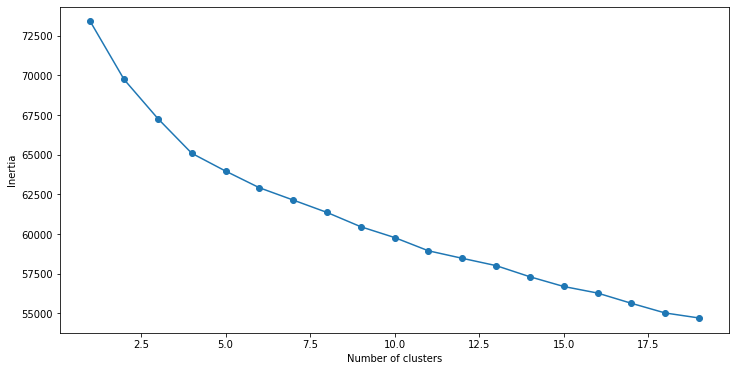

In [4]:
frame = pd.DataFrame({'Cluster':range(1,20), 'SSE':SSE})
plt.figure(figsize=(12,6))
plt.plot(frame['Cluster'], frame['SSE'], marker='o')
plt.xlabel('Number of clusters')
plt.ylabel('Inertia')

In [3]:
# https://www.analyticsvidhya.com/blog/2019/08/comprehensive-guide-k-means-clustering/#k-means-clustering-python-code

kmeans = KMeans(n_jobs=-1, n_clusters=4, init='k-means++')
kmeans.fit(X_tr_tfidf_w2v)
pred = kmeans.predict(X_tr_tfidf_w2v)
labels = kmeans.labels_

In [4]:
frame = pd.DataFrame(X_tr_tfidf_w2v)
frame['cluster'] = pred

In [5]:
with open('kmeans_result.pickle', 'wb') as f:
    pickle.dump(frame, f)

In [4]:
with open('kmeans_result_labels.pickle', 'wb') as f:
    pickle.dump(labels, f)

In [7]:
from MulticoreTSNE import MulticoreTSNE as TSNE

In [4]:
data = X_tr_tfidf_w2v.todense()
embeddings = TSNE(n_jobs=-1).fit_transform(data)

In [2]:
with open('kmeans_result_labels.pickle', 'rb') as f:
    labels = pickle.load(f)

In [6]:
with open('TSNE_result.pickle', 'wb') as f:
    pickle.dump(embeddings, f)

In [3]:
with open('TSNE_result.pickle', 'rb') as f:
    embeddings = pickle.load(f)

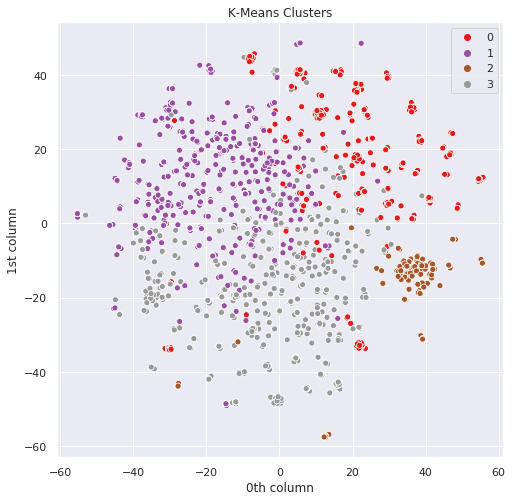

In [7]:
sns.set()
plt.figure(figsize=(8, 8))
plt.title('K-Means Clusters')
plt.xlabel('0th column')
plt.ylabel('1st column')
sns.scatterplot(x=embeddings[:,0], y=embeddings[:,1], hue=labels, palette='Set1')

In [2]:
with open('kmeans_result_labels.pickle', 'rb') as f:
    kmeans_label = pickle.load(f)

In [3]:
kmeans_label.shape

(3500,)

In [4]:
kmeans_label = kmeans_label.tolist()

In [5]:
kmeans_label_0_index = []
kmeans_label_1_index = []
kmeans_label_2_index = []
kmeans_label_3_index = []

In [7]:
for i in range(len(kmeans_label)):
    if kmeans_label[i] == 0:
        kmeans_label_0_index.append(i)
        
for i in range(len(kmeans_label)):
    if kmeans_label[i] == 1:
        kmeans_label_1_index.append(i)
        
for i in range(len(kmeans_label)):
    if kmeans_label[i] == 2:
        kmeans_label_2_index.append(i)
        
for i in range(len(kmeans_label)):
    if kmeans_label[i] == 3:
        kmeans_label_3_index.append(i)

In [8]:
# https://www.geeksforgeeks.org/generating-word-cloud-python/

# Reads 'Youtube04-Eminem.csv' file 
df = pd.read_csv(r"Essay.csv", encoding ="utf-8") 


In [9]:
df_0 = df[df.index.isin(kmeans_label_0_index)]
df_1 = df[df.index.isin(kmeans_label_1_index)]
df_2 = df[df.index.isin(kmeans_label_2_index)]
df_3 = df[df.index.isin(kmeans_label_3_index)]

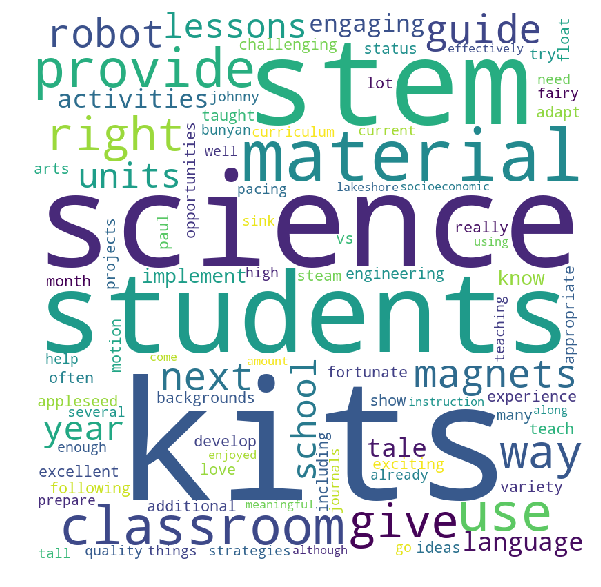

In [10]:
comment_words = ' '
stopwords = set(STOPWORDS) 

# iterate through the csv file 
for row in df_0: 
        row = str(row) 
        tokens = row.split() 
        for i in range(len(tokens)): 
            tokens[i] = tokens[i].lower() 
        for words in tokens: 
            comment_words = comment_words + words + ' '


wordcloud = WordCloud(width = 800, height = 800, \
                      background_color ='white', \
                      stopwords = stopwords, \
                      min_font_size = 10).generate(comment_words) 


plt.figure(figsize = (8, 8), facecolor = None) 
plt.imshow(wordcloud) 
plt.axis("off") 
plt.tight_layout(pad = 0) 

plt.show() 


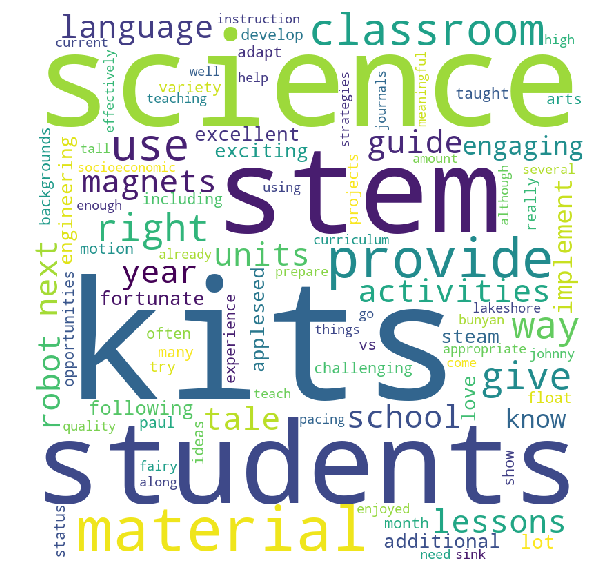

In [11]:
comment_words = ' '
stopwords = set(STOPWORDS) 

# iterate through the csv file 
for row in df_1: 
        row = str(row) 
        tokens = row.split() 
        for i in range(len(tokens)): 
            tokens[i] = tokens[i].lower() 
        for words in tokens: 
            comment_words = comment_words + words + ' '


wordcloud = WordCloud(width = 800, height = 800, \
                      background_color ='white', \
                      stopwords = stopwords, \
                      min_font_size = 10).generate(comment_words) 


plt.figure(figsize = (8, 8), facecolor = None) 
plt.imshow(wordcloud) 
plt.axis("off") 
plt.tight_layout(pad = 0) 

plt.show() 

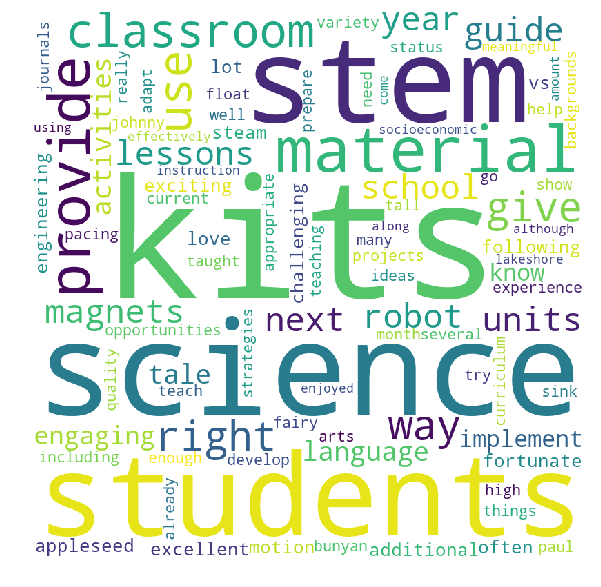

In [12]:
comment_words = ' '
stopwords = set(STOPWORDS) 

# iterate through the csv file 
for row in df_2: 
        row = str(row) 
        tokens = row.split() 
        for i in range(len(tokens)): 
            tokens[i] = tokens[i].lower() 
        for words in tokens: 
            comment_words = comment_words + words + ' '


wordcloud = WordCloud(width = 800, height = 800, \
                      background_color ='white', \
                      stopwords = stopwords, \
                      min_font_size = 10).generate(comment_words) 


plt.figure(figsize = (8, 8), facecolor = None) 
plt.imshow(wordcloud) 
plt.axis("off") 
plt.tight_layout(pad = 0) 

plt.show() 

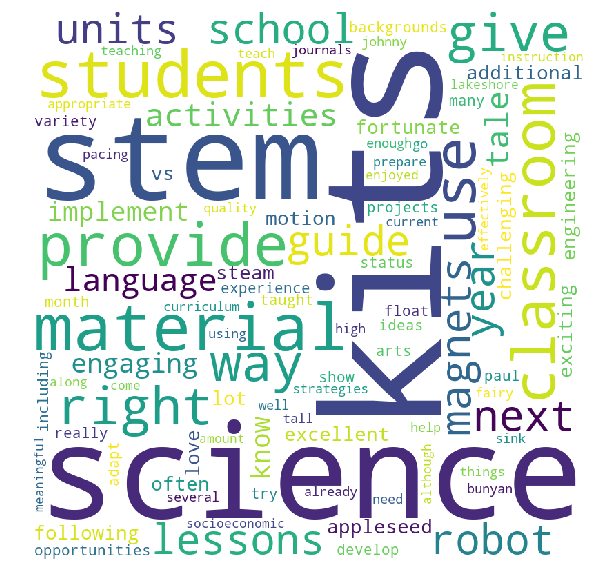

In [13]:
comment_words = ' '
stopwords = set(STOPWORDS) 

# iterate through the csv file 
for row in df_3: 
        row = str(row) 
        tokens = row.split() 
        for i in range(len(tokens)): 
            tokens[i] = tokens[i].lower() 
        for words in tokens: 
            comment_words = comment_words + words + ' '


wordcloud = WordCloud(width = 800, height = 800, \
                      background_color ='white', \
                      stopwords = stopwords, \
                      min_font_size = 10).generate(comment_words) 


plt.figure(figsize = (8, 8), facecolor = None) 
plt.imshow(wordcloud) 
plt.axis("off") 
plt.tight_layout(pad = 0) 

plt.show() 

# Agglomerative Clustering

In [1]:
import pickle
import scipy.cluster.hierarchy as sch
import matplotlib.pyplot as plt
import matplotlib.pylab as plab
from sklearn.cluster import AgglomerativeClustering
import seaborn as sns
import scipy

In [2]:
with open('tfidf_w2v.pickle', 'rb') as f:
    X_tr_tfidf_w2v, y_train, X_test_tfidf_w2v, y_test = pickle.load(f)

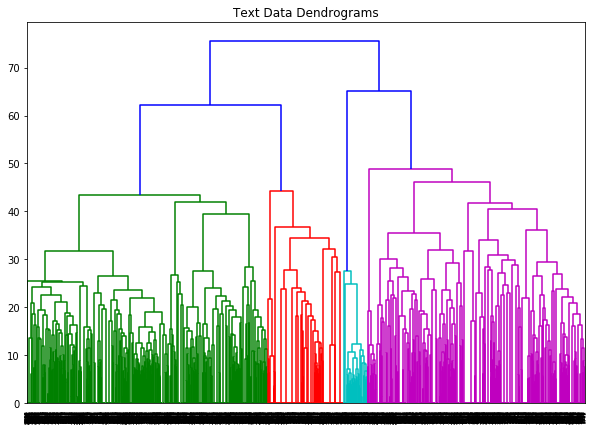

In [3]:
# https://stackabuse.com/hierarchical-clustering-with-python-and-scikit-learn/

plt.figure(figsize=(10, 7))
plt.title("Text Data Dendrograms")
dend = sch.dendrogram(sch.linkage(X_tr_tfidf_w2v.toarray(), method='ward'))

In [4]:
cluster = AgglomerativeClustering(n_clusters = 4, affinity='euclidean', linkage = 'ward')
cluster.fit_predict(X_tr_tfidf_w2v.toarray())
labels = cluster.labels_

In [5]:
with open('cluster_labels_agglomerative.pickle', 'wb') as f:
    pickle.dump(labels, f)

In [3]:
with open('cluster_labels_agglomerative.pickle', 'rb') as f:
    labels = pickle.load(f)

In [12]:
print(labels)

[3 3 0 ... 0 0 3]


In [4]:
data = X_tr_tfidf_w2v.todense()

In [5]:
data.shape

(3500, 694)

In [7]:
from MulticoreTSNE import MulticoreTSNE as TSNE

In [4]:
embeddings = TSNE(n_jobs=-1).fit_transform(data)

In [6]:
with open('TSNE_result.pickle', 'wb') as f:
    pickle.dump(embeddings, f)

In [11]:
with open('TSNE_result.pickle', 'rb') as f:
    embeddings = pickle.load(f)

In [13]:
embeddings.shape

(3500, 2)

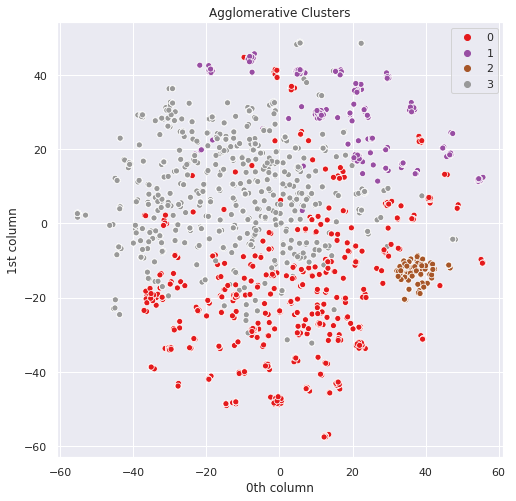

In [6]:
sns.set()
plt.figure(figsize=(8, 8))
plt.title('Agglomerative Clusters')
plt.xlabel('0th column')
plt.ylabel('1st column')
sns.scatterplot(x=embeddings[:,0], y=embeddings[:,1], hue=labels, palette='Set1')

In [2]:
with open('cluster_labels_agglomerative.pickle', 'rb') as f:
    agglo_label = pickle.load(f)

In [3]:
agglo_label.shape

(3500,)

In [4]:
agglo_label = agglo_label.tolist()

In [5]:
agglo_label_0_index = []
agglo_label_1_index = []
agglo_label_2_index = []
agglo_label_3_index = []

In [7]:
for i in range(len(agglo_label)):
    if agglo_label[i] == 0:
        agglo_label_0_index.append(i)
        
for i in range(len(agglo_label)):
    if agglo_label[i] == 1:
        agglo_label_1_index.append(i)
        
for i in range(len(agglo_label)):
    if agglo_label[i] == 2:
        agglo_label_2_index.append(i)
        
for i in range(len(agglo_label)):
    if agglo_label[i] == 3:
        agglo_label_3_index.append(i)

In [8]:
# https://www.geeksforgeeks.org/generating-word-cloud-python/

# Reads 'Youtube04-Eminem.csv' file 
df = pd.read_csv(r"Essay.csv", encoding ="utf-8") 


In [9]:
df_0 = df[df.index.isin(agglo_label_0_index)]
df_1 = df[df.index.isin(agglo_label_1_index)]
df_2 = df[df.index.isin(agglo_label_2_index)]
df_3 = df[df.index.isin(agglo_label_3_index)]

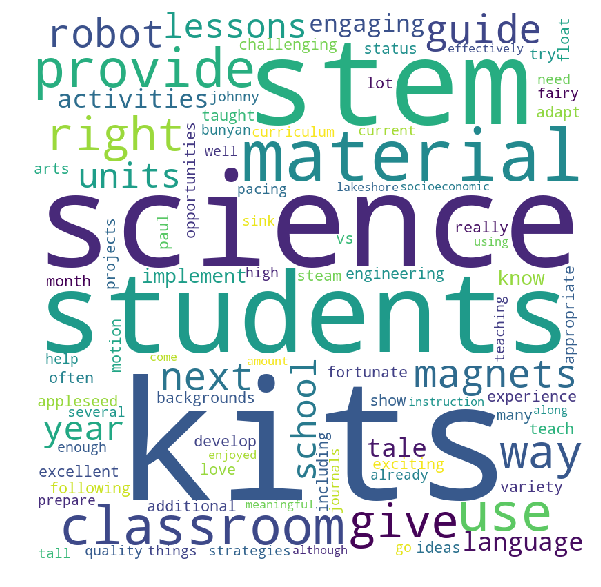

In [10]:
comment_words = ' '
stopwords = set(STOPWORDS) 

# iterate through the csv file 
for row in df_0: 
        row = str(row) 
        tokens = row.split() 
        for i in range(len(tokens)): 
            tokens[i] = tokens[i].lower() 
        for words in tokens: 
            comment_words = comment_words + words + ' '


wordcloud = WordCloud(width = 800, height = 800, \
                      background_color ='white', \
                      stopwords = stopwords, \
                      min_font_size = 10).generate(comment_words) 


plt.figure(figsize = (8, 8), facecolor = None) 
plt.imshow(wordcloud) 
plt.axis("off") 
plt.tight_layout(pad = 0) 

plt.show() 


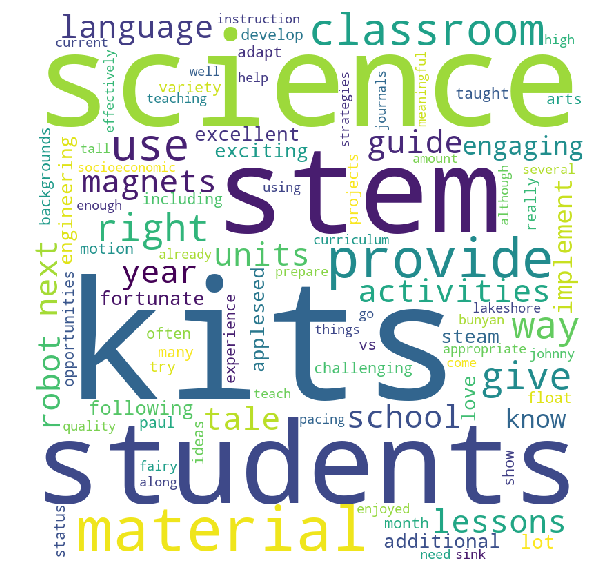

In [11]:
comment_words = ' '
stopwords = set(STOPWORDS) 

# iterate through the csv file 
for row in df_1: 
        row = str(row) 
        tokens = row.split() 
        for i in range(len(tokens)): 
            tokens[i] = tokens[i].lower() 
        for words in tokens: 
            comment_words = comment_words + words + ' '


wordcloud = WordCloud(width = 800, height = 800, \
                      background_color ='white', \
                      stopwords = stopwords, \
                      min_font_size = 10).generate(comment_words) 


plt.figure(figsize = (8, 8), facecolor = None) 
plt.imshow(wordcloud) 
plt.axis("off") 
plt.tight_layout(pad = 0) 

plt.show() 

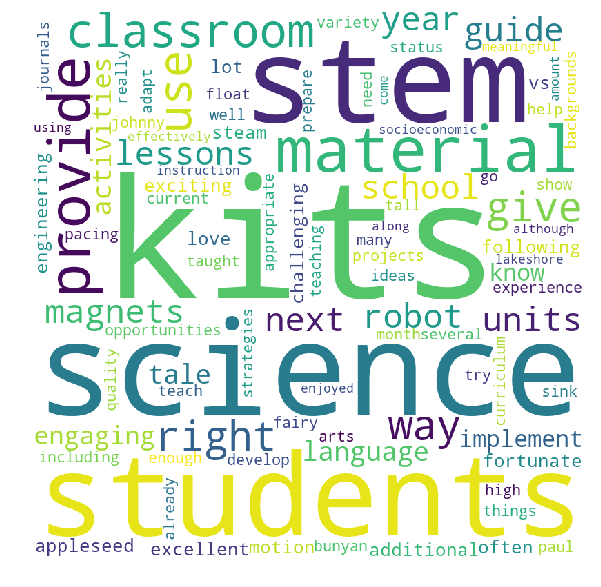

In [12]:
comment_words = ' '
stopwords = set(STOPWORDS) 

# iterate through the csv file 
for row in df_2: 
        row = str(row) 
        tokens = row.split() 
        for i in range(len(tokens)): 
            tokens[i] = tokens[i].lower() 
        for words in tokens: 
            comment_words = comment_words + words + ' '


wordcloud = WordCloud(width = 800, height = 800, \
                      background_color ='white', \
                      stopwords = stopwords, \
                      min_font_size = 10).generate(comment_words) 


plt.figure(figsize = (8, 8), facecolor = None) 
plt.imshow(wordcloud) 
plt.axis("off") 
plt.tight_layout(pad = 0) 

plt.show() 

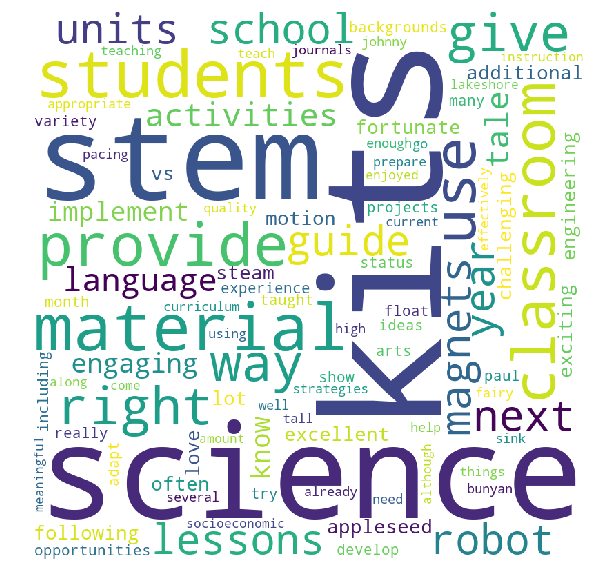

In [13]:
comment_words = ' '
stopwords = set(STOPWORDS) 

# iterate through the csv file 
for row in df_3: 
        row = str(row) 
        tokens = row.split() 
        for i in range(len(tokens)): 
            tokens[i] = tokens[i].lower() 
        for words in tokens: 
            comment_words = comment_words + words + ' '


wordcloud = WordCloud(width = 800, height = 800, \
                      background_color ='white', \
                      stopwords = stopwords, \
                      min_font_size = 10).generate(comment_words) 


plt.figure(figsize = (8, 8), facecolor = None) 
plt.imshow(wordcloud) 
plt.axis("off") 
plt.tight_layout(pad = 0) 

plt.show() 

# DBSCAN

In [2]:
with open('tfidf_w2v.pickle', 'rb') as f:
    X_tr_tfidf_w2v, y_train, X_test_tfidf_w2v, y_test = pickle.load(f)

In [3]:
X_tr_tfidf_w2v.shape

(3500, 694)

In [4]:
nn=NearestNeighbors(n_neighbors=2*694, algorithm='auto').fit(X_tr_tfidf_w2v)

In [5]:
distance, indice = nn.kneighbors(X_tr_tfidf_w2v)

In [6]:
print(distance.shape)

(3500, 1388)


In [8]:
print(distance[:,1387])

[6.51071543 5.78909655 6.9883725  ... 5.95337529 5.49920029 5.73573081]


In [9]:
distances=np.sort(distance[:,1387])

In [10]:
with open('DBSCAN_distances.pickle', 'wb') as f:
    pickle.dump(distances, f)

In [11]:
with open('DBSCAN_distances.pickle', 'rb') as f:
    distances = pickle.load(f)

In [12]:
distances.shape

(3500,)

In [13]:
print(distances)

[ 4.9364587   4.9364587   4.9364587  ... 10.03144958 10.04344863
 10.04344863]


In [14]:
points = [i for i in range(3500)]

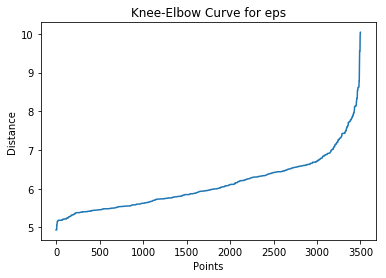

In [19]:
plt.plot(points, distances)
plt.ylabel('Distance')
plt.xlabel('Points')
plt.title('Knee-Elbow Curve for eps')
plt.show()

In [1]:
from sklearn.neighbors import NearestNeighbors
import pickle
import numpy as np
import matplotlib.pyplot as plt
from sklearn.cluster import DBSCAN
import seaborn as sns

In [2]:
with open('tfidf_w2v.pickle', 'rb') as f:
    X_tr_tfidf_w2v, y_train, X_test_tfidf_w2v, y_test = pickle.load(f)

In [3]:
X_tr_tfidf_w2v.shape

(3500, 694)

In [4]:
clustering = DBSCAN(eps=7, min_samples=2**694)
clustering.fit_predict(X_tr_tfidf_w2v.toarray())
labels = clustering.labels_

In [5]:
with open('DBSCAN_labels.pickle', 'wb') as f:
    pickle.dump(labels, f)

In [6]:
with open('TSNE_result.pickle', 'rb') as f:
    embeddings = pickle.load(f)

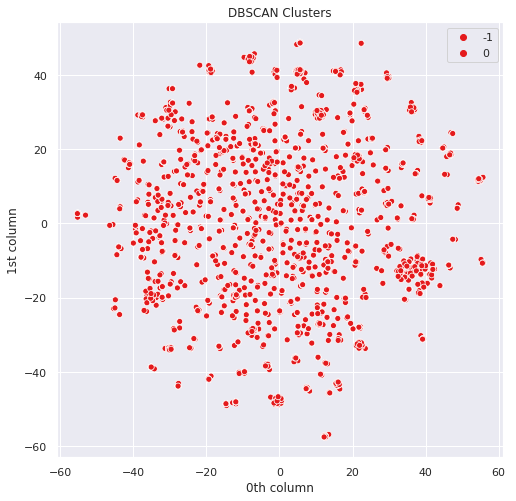

In [7]:
sns.set()
plt.figure(figsize=(8, 8))
plt.title('DBSCAN Clusters')
plt.xlabel('0th column')
plt.ylabel('1st column')
sns.scatterplot(x=embeddings[:,0], y=embeddings[:,1], hue=labels, palette='Set1')

In [26]:
with open('DBSCAN_labels.pickle', 'rb') as f:
    dbscan_label = pickle.load(f)

In [27]:
dbscan_label.shape

(3500,)

In [28]:
dbscan_label = dbscan_label.tolist()

In [29]:
dbscan_label_0_index = []
dbscan_label_minus_1_index = []

In [30]:
for i in range(len(dbscan_label)):
    if dbscan_label[i] == 0:
        dbscan_label_0_index.append(i)
        
for i in range(len(dbscan_label)):
    if dbscan_label[i] == -1:
        dbscan_label_minus_1_index.append(i)

In [31]:
# https://www.geeksforgeeks.org/generating-word-cloud-python/

# Reads 'Youtube04-Eminem.csv' file 
df = pd.read_csv(r"Essay.csv", encoding ="utf-8") 


In [33]:
df_0 = df[df.index.isin(dbscan_label_0_index)]
df_minus_1 = df[df.index.isin(dbscan_label_minus_1_index)]

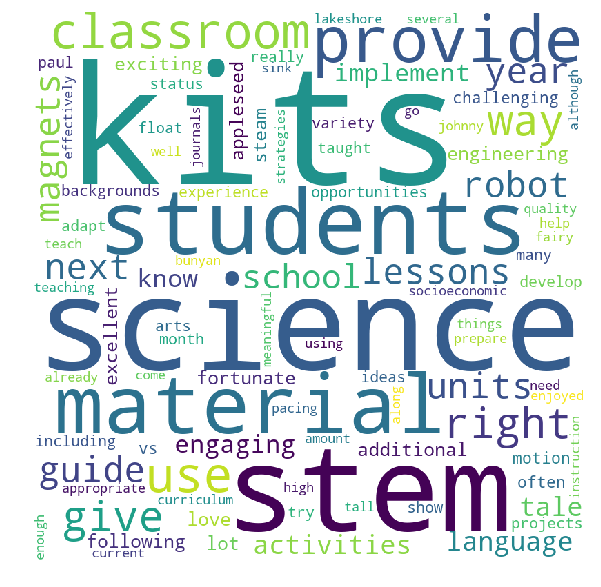

In [34]:
comment_words = ' '
stopwords = set(STOPWORDS) 

# iterate through the csv file 
for row in df_0: 
        row = str(row) 
        tokens = row.split() 
        for i in range(len(tokens)): 
            tokens[i] = tokens[i].lower() 
        for words in tokens: 
            comment_words = comment_words + words + ' '


wordcloud = WordCloud(width = 800, height = 800, \
                      background_color ='white', \
                      stopwords = stopwords, \
                      min_font_size = 10).generate(comment_words) 


plt.figure(figsize = (8, 8), facecolor = None) 
plt.imshow(wordcloud) 
plt.axis("off") 
plt.tight_layout(pad = 0) 

plt.show() 


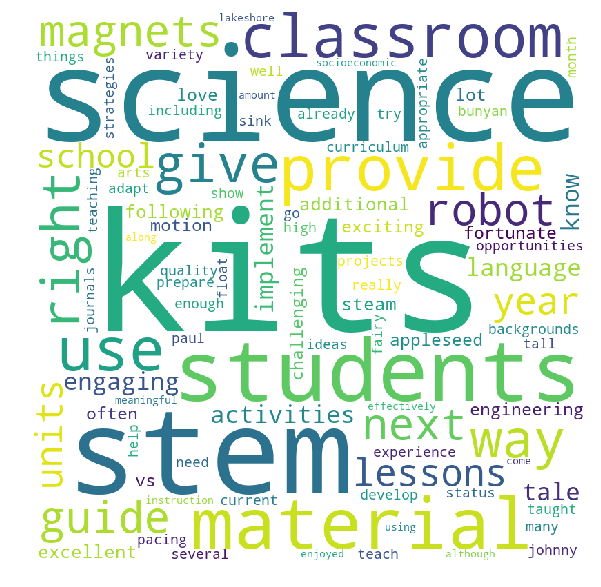

In [35]:
comment_words = ' '
stopwords = set(STOPWORDS) 

# iterate through the csv file 
for row in df_minus_1: 
        row = str(row) 
        tokens = row.split() 
        for i in range(len(tokens)): 
            tokens[i] = tokens[i].lower() 
        for words in tokens: 
            comment_words = comment_words + words + ' '


wordcloud = WordCloud(width = 800, height = 800, \
                      background_color ='white', \
                      stopwords = stopwords, \
                      min_font_size = 10).generate(comment_words) 


plt.figure(figsize = (8, 8), facecolor = None) 
plt.imshow(wordcloud) 
plt.axis("off") 
plt.tight_layout(pad = 0) 

plt.show() 

# Conclusion

For each of the clustering techniques here are the observations:
    1. For KMeans, best number of clusters are 4
    2. For Agglomerative-Hierarchical Clustering, best number of clusters are 4. The dendrogram is shown in the picture.
    3. For DBSCAN, eps is coming out to be 7.

# Summary

For each of the Clustering techniques, Graphs, Dendrogram, Clusters and Wordcloud is printed.